# Big 5 European Leagues: Focus on Top Scorers
## Season 2022-23 - November 2022

In [1]:
## Initial Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.gridspec as gridspec
from highlight_text import ax_text, fig_text

from PIL import Image
import urllib
import json
import os
import matplotlib.font_manager as fm
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.colors import LinearSegmentedColormap, NoNorm
from highlight_text import fig_text

from mplsoccer import Radar, FontManager, grid
import scipy.stats as stats

import math
# We'll only use a vertical pitch for this tutorial
from mplsoccer import VerticalPitch

gradient = [
    '#de6f57',
    '#d5724d',
    '#cb7644',
    '#c0783e',
    '#b57b38',
    '#a97d35',
    '#9e7f34',
    '#928134',
    '#878137',
    '#7c823a',
    '#71823f',
    '#668244',
    '#5c814a',
    '#528050',
    '#497f56',
    '#407d5b',
    '#387b61',
    '#317966',
    '#2c776a',
    '#29756e',
    '#287271',
]
soc_cm = LinearSegmentedColormap.from_list('SOC', gradient, N=50)
cm.register_cmap(name='SOC', cmap=soc_cm)


font_path = "../assets/fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if y.split(".")[-1] == "ttf":
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

plt.style.use("../assets/stylesheets/soc_base.mplstyle")


# Shot areas
## Preprocessing

In [2]:
df_ita = pd.read_csv('../data/SerieA_22_23_match_shots.csv', index_col='Ind')
df_ita = df_ita.query('player_name == "Victor Osimhen"')
df_eng = pd.read_csv('../data/Premier_22_23_match_shots.csv', index_col='Ind')
df_eng = df_eng.query('player_name == "Erling Braut Haaland"')
df_esp = pd.read_csv('../data/Liga_22_23_match_shots.csv', index_col='Ind')
df_esp = df_esp.query('player_name == "Robert Lewandowski"')
df_fra = pd.read_csv('../data/Ligue1_22_23_match_shots.csv', index_col='Ind')
df_fra = df_fra.query('player_name == "Kylian Mbappé"')
df_ger = pd.read_csv('../data/Bundesliga_22_23_match_shots.csv', index_col='Ind')
df_ger = df_ger.query('player_name == "Christopher Nkunku"')

df = pd.concat([df_ita, df_eng, df_esp, df_fra, df_ger], axis=0)

columns = ['player_id', 'player_name', 'team_id', 'team_color', 'is_on_target', 'event_type', 'shot_type', 'situation', 'expected_goals', 'expected_goals_on_target']
df2 = df[columns].copy()
df2['Goal'] = [1 if x=='Goal' else 0 for x in df2['event_type']]
columns = ['player_id', 'player_name', 'team_id', 'team_color', 'Goal', 'situation', 'expected_goals', 'expected_goals_on_target']
df2 = df2[columns]
df3 = df2.groupby(['player_name', 'team_id', 'team_color']).agg({'Goal':'sum'})
df3 = df3.sort_values(by='Goal', ascending=False).reset_index()

df4 = df2[df2['situation'] != 'Penalty'].reset_index(drop=True)
df4['shot'] = 1
df4.loc[df4['expected_goals_on_target'].isnull(),'OT'] = False
df4.loc[df4['expected_goals_on_target'].notnull(), 'OT'] = True
df4 = df4.groupby(['player_name', 'team_id', 'team_color']).agg({'Goal':'sum', 'expected_goals':'sum', 'expected_goals_on_target':'sum', 'OT':'sum', 'situation':'count'}).reset_index()
df4 = df4.rename(columns={'situation':'Shot', 'Goal':'Goal (no penalty)', 'OT':'Shot OT', 'expected_goals':'npxG', 'expected_goals_on_target':'npxGOT'})
df4['np: 1 goal each shot'] = round(df4['Shot']/df4['Goal (no penalty)'],2)
df4['np: 1 goal each shot OT'] = df4['Shot OT']/df4['Goal (no penalty)']
df5 = df3.merge(df4, how='inner', on=['player_name','team_id','team_color'])
df5 = df5.sort_values(by='Shot', ascending=False).reset_index(drop=True)

In [3]:
pitch = VerticalPitch(pitch_type='uefa')
zone_areas = {
    'zone_1':{
        'x_lower_bound': 54.16, 'x_upper_bound': 68,
        'y_lower_bound': 88.5, 'y_upper_bound': 105,
    },
    'zone_2':{
        'x_lower_bound': 0, 'x_upper_bound': 13.84,
        'y_lower_bound': 88.5, 'y_upper_bound': 105,
    },
    'zone_3':{
        'x_lower_bound': 54.16, 'x_upper_bound': 68,
        'y_lower_bound': 20, 'y_upper_bound': 88.5,
    },
    'zone_4':{
        'x_lower_bound': 0, 'x_upper_bound': 13.84,
        'y_lower_bound': 20, 'y_upper_bound': 88.5,
    },
    'zone_5':{
        'x_lower_bound': 13.84, 'x_upper_bound': 24.84,
        'y_lower_bound': 88.5, 'y_upper_bound': 105,
    },
    'zone_6':{
        'x_lower_bound': 43.16, 'x_upper_bound': 54.16,
        'y_lower_bound': 88.5, 'y_upper_bound': 105,
    },
    'zone_7':{
        'x_lower_bound': 24.84, 'x_upper_bound': 43.16,
        'y_lower_bound': 88.5, 'y_upper_bound': 99.5,
    },
    'zone_8':{
        'x_lower_bound': 24.84, 'x_upper_bound': 43.16,
        'y_lower_bound': 99.5, 'y_upper_bound': 105,
    },
    'zone_9':{
        'x_lower_bound': 13.84, 'x_upper_bound': 24.84,
        'y_lower_bound': 75, 'y_upper_bound': 88.5,
    },
    'zone_10':{
        'x_lower_bound': 43.16, 'x_upper_bound': 54.16,
        'y_lower_bound': 75, 'y_upper_bound': 88.5,
    },
    'zone_11':{
        'x_lower_bound': 24.84, 'x_upper_bound': 43.16,
        'y_lower_bound': 75, 'y_upper_bound': 88.5,
    },
    'zone_12':{
        'x_lower_bound': 13.84, 'x_upper_bound': 54.16,
        'y_lower_bound': 20, 'y_upper_bound': 75,
    }
}

def assign_shot_zone(x,y):
    '''
    This function returns the zone based on the x & y coordinates of the shot
    taken.
    Args:
        - x (float): the x position of the shot based on a vertical grid.
        - y (float): the y position of the shot based on a vertical grid.
    '''

    global zone_areas
    # Conditions
    for zone in zone_areas:
        if (x >= zone_areas[zone]['x_lower_bound']) & (x <= zone_areas[zone]['x_upper_bound']):
            if (y >= zone_areas[zone]['y_lower_bound']) & (y <= zone_areas[zone]['y_upper_bound']):
                return zone

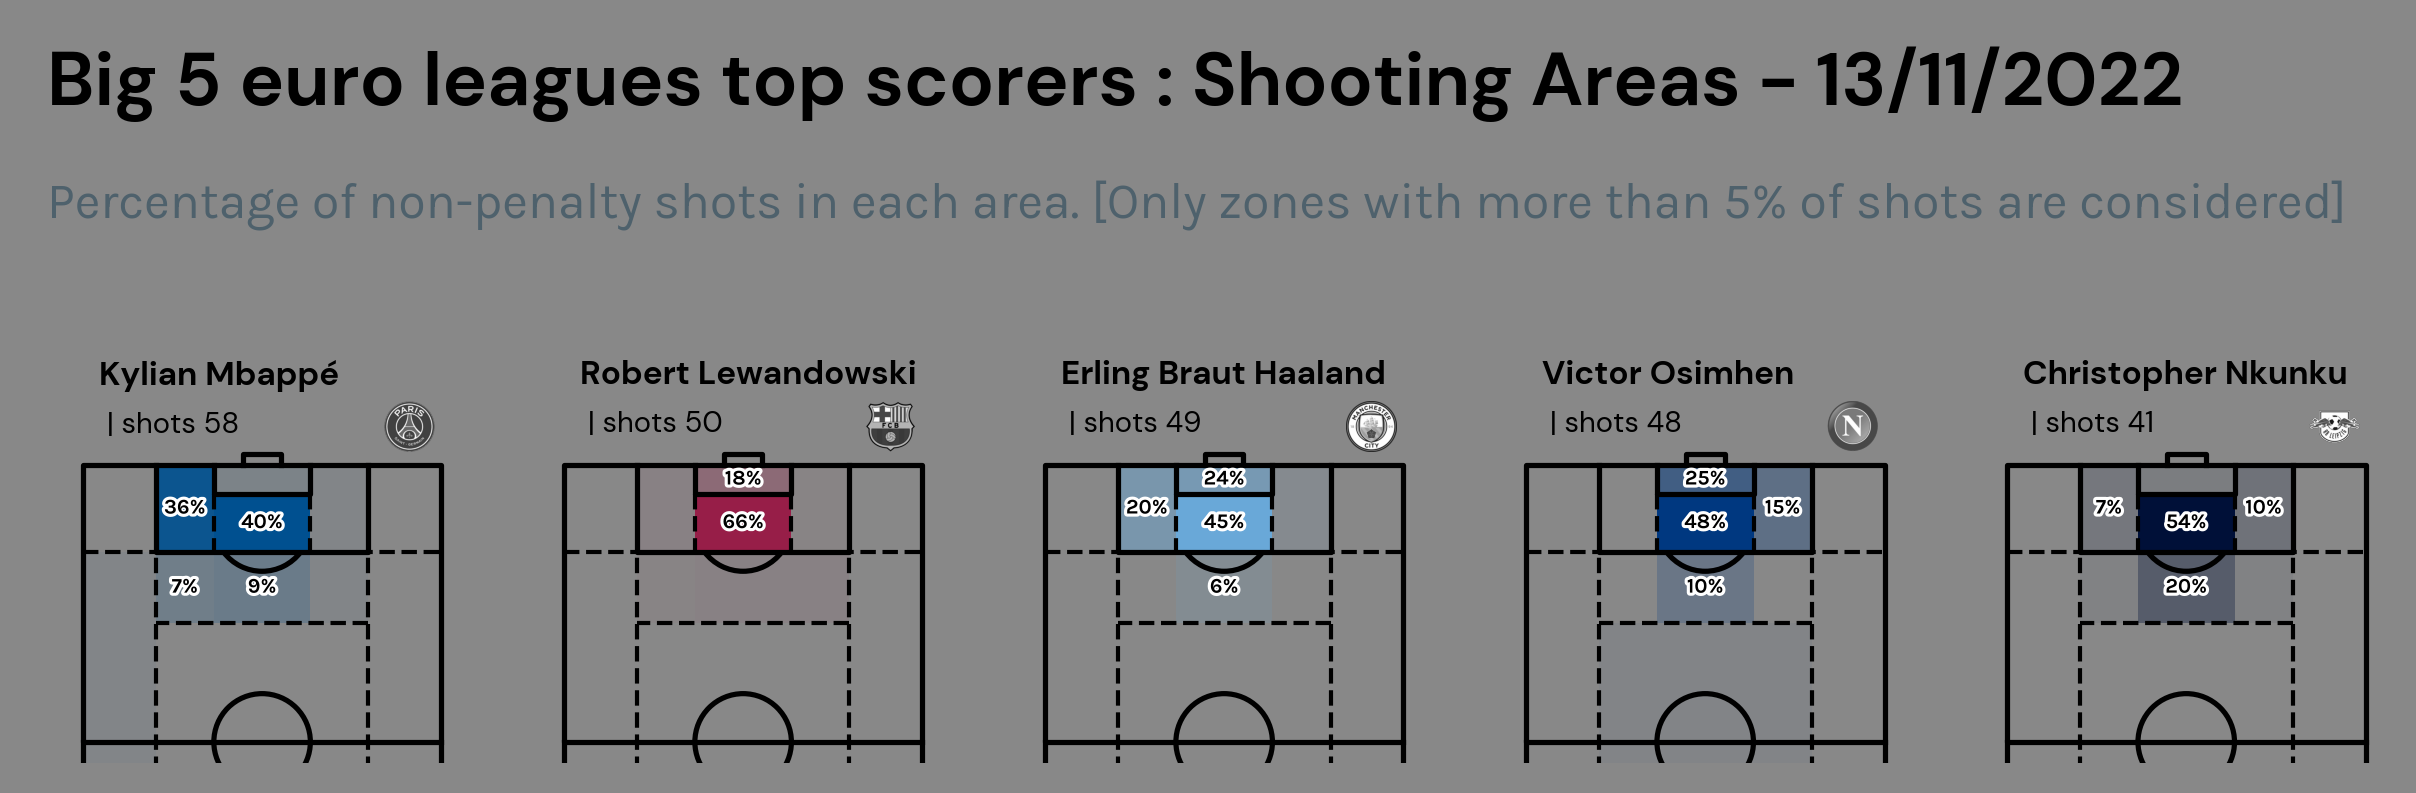

In [4]:
df1 = df.rename(columns={'x':'y', 'y':'x'})
df1 = df1[df1['situation'] != 'Penalty'].reset_index(drop=True)
df1['zone_area'] = [assign_shot_zone(x,y) for x,y in zip(df1['x'], df1['y'])]

data = df1.groupby(['player_name', 'team_id', 'team_color', 'zone_area']).apply(lambda x: x.shape[0]).reset_index()
data.rename(columns={0:'num_shots'}, inplace=True)

total_shots = data.groupby(['player_name'])['num_shots'].sum().reset_index()
total_shots.rename(columns={'num_shots':'total_shots'}, inplace=True)

data = pd.merge(data, total_shots, on='player_name', how='left')
data['pct_shots'] = data['num_shots']/data['total_shots']

def plot_shot_location(ax, fig, player, df=data):
    '''
    This functions plots the shot location grid for a team.
    '''
    global zone_areas
    data = df.copy()

    pitch = VerticalPitch(
        pitch_type='uefa',
        pitch_color="#888888",
        half=True,
        goal_type='box',
        linewidth=1.25,
        line_color='black',
        spot_scale=0.0
    )
    pitch.draw(ax = ax)

    plot_df = data[data['player_name'] == player]
    max_value = plot_df['pct_shots'].max()
    team_color = plot_df['team_color'].iloc[0]
    team_id = plot_df['team_id'].iloc[0]
    total_shots = plot_df['total_shots'].iloc[0]

    # Grids
    ax.plot([13.84, 13.84], [40, 88.5], ls='--', color='black', lw=1)
    ax.plot([54.16, 54.16], [40, 88.5], ls='--', color='black', lw=1)
    ax.plot([24.84, 24.84], [99.5, 88.5], ls='--', color='black', lw=1)
    ax.plot([43.16, 43.16], [99.5, 88.5], ls='--', color='black', lw=1)

    ax.plot([68, 54.16], [88.5,88.5], ls='--', color='black', lw=1)
    ax.plot([0.5, 13.84], [88.5,88.5], ls='--', color='black', lw=1)
    ax.plot([13.84, 54.16], [75,75], ls='--', color='black', lw=1)

    for zone in plot_df['zone_area']:
        shot_pct = plot_df[plot_df['zone_area'] == zone]['pct_shots'].iloc[0]
        x_lim = [zone_areas[zone]['x_lower_bound'], zone_areas[zone]['x_upper_bound']]
        y1 = zone_areas[zone]['y_lower_bound']
        y2 = zone_areas[zone]['y_upper_bound']
        ax.fill_between(
            x=x_lim, 
            y1=y1, y2=y2, 
            color=team_color, alpha=(shot_pct/max_value),
            zorder=0, ec='None')
        if shot_pct > 0.05:
            x_pos = x_lim[0] + abs(x_lim[0] - x_lim[1])/2
            if y1 == 20:
                y1 = 58
            y_pos = y1 + abs(y1 - y2)/2
            text_ = ax.annotate(
                xy=(x_pos, y_pos),
                text=f'{shot_pct:.0%}',
                ha='center',
                va='center',
                color='black',
                weight='bold',
                size=5
            )
            text_.set_path_effects(
                [path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()]
            )
    # -- Transformation functions
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1])
    ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])
    DC_to_FC = ax.transData.transform
    FC_to_NFC = fig.transFigure.inverted().transform
    # -- Take data coordinates and transform them to normalized figure coordinates
    DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
    ax_coords = DC_to_NFC((14,85.5))
    ax_size = 0.028
    image_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_size, ax_size],
        fc='None', anchor='C'
    )
    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_id:.0f}.png')).convert('LA')
    image_ax.imshow(club_icon)
    image_ax.axis('off')
    ax_text(
        x=65, y=125,
        s=f'{player}\n <| shots {total_shots:.0f}>',
        highlight_textprops=[{'size':7, 'weight':'normal'}],
        ax=ax,
        weight='bold',
        size=8,
        font='DM Sans'
    )
    
    return ax

order_players = data.sort_values(by='total_shots', ascending=False)
player_list = []
for _, row in order_players.iterrows():
    if (row['player_name'] not in player_list):
        player_list.append(row['player_name'])

layout_ = '''
    ABCDE
'''

height_ratios = [1]*1

fig = plt.figure(figsize=(10,6), dpi=300, facecolor="#888888")
axs = fig.subplot_mosaic(
    layout_, 
    gridspec_kw={
        'height_ratios':height_ratios,
    }
)

counter = 0
for k, ax in axs.items():
    player = player_list[counter]
    plot_shot_location(ax, fig, player=player)
    counter += 1

fig_text(
    x = 0.12, y = .77, 
    s = "Big 5 euro leagues top scorers : Shooting Areas - 13/11/2022",
    va = "bottom", ha = "left",
    fontsize = 18, color = "black", font = "DM Sans", weight = "bold"
)
fig_text(
	x = 0.12, y = .71, 
    s = "Percentage of non-penalty shots in each area. [Only zones with more than 5% of shots are considered]",
	va = "bottom", ha = "left",
	fontsize = 12, color = "#4E616C", font = "Karla"
)

plt.savefig(
	"../figures/Big5_top_scorer_shots_map .png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

# Who is performing better?
## Goal Score vs npxG

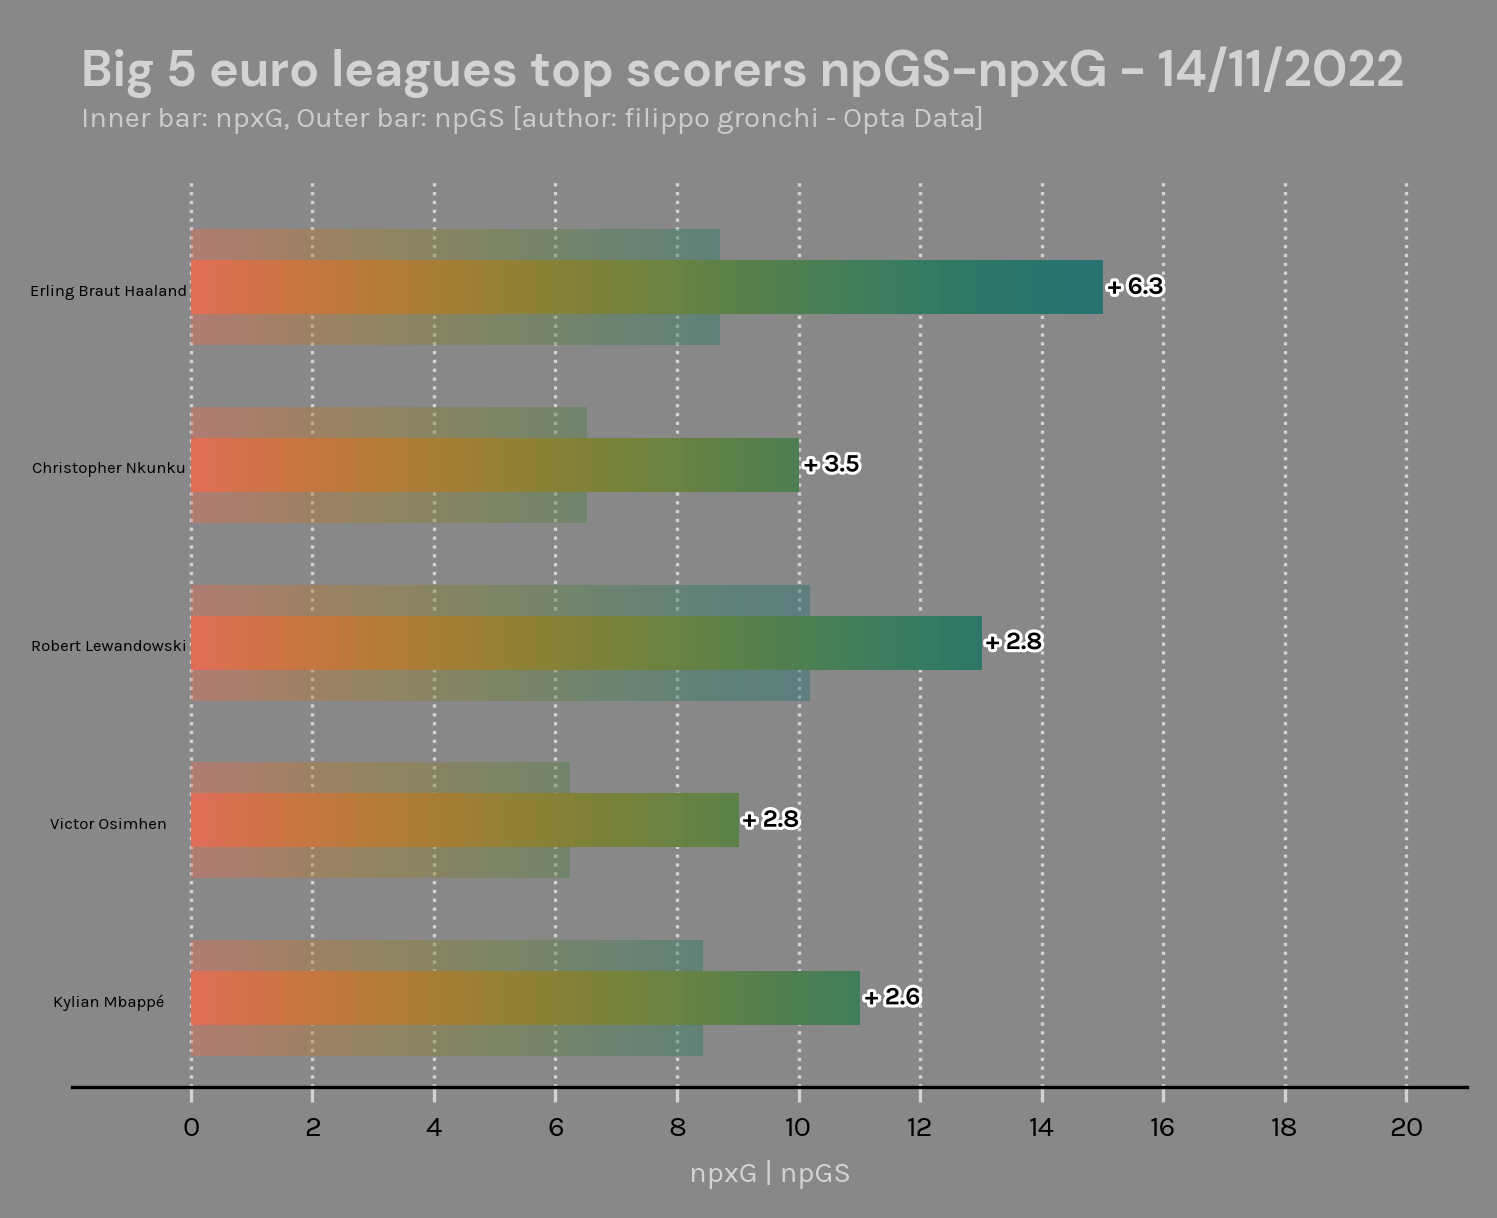

In [5]:
# removing penalty lines
data = df.copy()
data = data.query('situation!="Penalty"')
data['GoalCount'] = 0
data.loc[data['event_type']=='Goal', 'GoalCount'] = 1
data = data.groupby(['player_name', 'team_id', 'team_color']).agg({'expected_goals':'sum', 'expected_goals_on_target':'sum', 'GoalCount':'sum', 'match_round':'count'}).reset_index()
data.loc[:,'npxGOT-npxG'] = data.loc[:,'expected_goals_on_target'] - data.loc[:,'expected_goals']
data = data.rename(columns={'expected_goals':'npxG', 'expected_goals_on_target':'npxGOT', 'match_round':'shots', 'GoalCount':'npGS'})
data.loc[:,'npGS-npxG'] = data.loc[:,'npGS'] - data.loc[:,'npxG'] 
data = data.sort_values(by='npGS-npxG', ascending=True).reset_index(drop=True)

fig = plt.figure(figsize=(6,4), dpi=300, facecolor = "#888888")
ax = plt.subplot(111, facecolor = "#888888")

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([])
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_label_text('npxG | npGS', size=7, color='lightgrey')
ax.tick_params(labelsize=7, color='lightgrey')
ax.grid(axis='x', color='lightgrey', ls=':')
# xG
bars_ = ax.barh(data.index, data['npxG'], height=0.65)
for bar in bars_:
    bar.set_zorder(1)
    bar.set_facecolor('none')
    x,y = bar.get_xy()
    w, h = bar.get_width(), bar.get_height()
    grad = np.atleast_2d(np.linspace(0,1*w/max(data['npxG']),256))
    ax.imshow(
        grad, extent=[x,x+w,y,y+h],
        aspect='auto', zorder=3, 
        norm=NoNorm(vmin=0,vmax=1), cmap='SOC', alpha=0.45
    )
# xGOT
bars_ = ax.barh(data.index, data['npGS'], height=0.3)
lim = ax.get_xlim()+ax.get_ylim()
for bar in bars_:
    bar.set_zorder(1)
    bar.set_facecolor('none')
    x,y = bar.get_xy()
    w, h = bar.get_width(), bar.get_height()
    grad = np.atleast_2d(np.linspace(0,1*w/max(data['npGS']),256))
    ax.imshow(
        grad, extent=[x,x+w,y,y+h], 
        aspect='auto', zorder=3, 
        norm=NoNorm(vmin=0,vmax=1), cmap='SOC'
    )

ax.set_xlim(-1.95,21)
ax.set_ylim(-.5,4.6)
#DC_to_FC = ax.transData.transform
#FC_to_NFC = fig.transFigure.inverted().transform
## -- Take data coordinates and transform them to normalized figure coordinates
#DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
for y in data.index:
    #ax_coords = DC_to_NFC((-1.35,y-.15))
    team_id = data['team_id'].iloc[y]
    player_name = data['player_name'].iloc[y]
    
    diff_xg = data['npGS-npxG'].iloc[y]
    npGS = data['npGS'].iloc[y]
    if diff_xg > 0:
        text_sign = '+'
    else:
        text_sign = ''
    ax_size = 0.02
    #image_ax = fig.add_axes(
    #    [ax_coords[0], ax_coords[1], ax_size, ax_size],
    #    fc='None', anchor='C'
    #)

    ax.annotate(
        xy=(-1.35, y - .02),
        text=player_name,
        size=4,
        ha='center',
        va='center'
    )
    text_ = ax.annotate(
        xy=(npGS, y),
        xytext=(8,0),
        text=f'{text_sign} {diff_xg:.1f}',
        size=6,
        ha='center',
        va='center',
        textcoords='offset points',
        weight='bold'
    )
    text_.set_path_effects(
        [path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()]
    )


fig_text(
    x = 0.13, y = .95, 
    s = "Big 5 euro leagues top scorers npGS-npxG - 14/11/2022",
    va = "bottom", ha = "left",
    fontsize = 12, color='lightgrey', font = "DM Sans", weight = "bold"
)
fig_text(
	x = 0.13, y = .92, 
    s = "Inner bar: npxG, Outer bar: npGS [author: filippo gronchi - Opta Data]",
	va = "bottom", ha = "left",
	fontsize = 7, color = "#cccccc", font = "Karla"
)

plt.savefig(
	"../figures/Big5_top_scorer_xg_gs.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

# Top scorers skill and positioning between all league forwards
## Preprocessing

In [6]:
## Minutes percentage table: preprocessing
df_passing = pd.read_csv('../data/big5_player_passing.csv', index_col='Ind')
df_possession = pd.read_csv('../data/big5_player_possession.csv', index_col='Ind')
df_shooting = pd.read_csv('../data/big5_player_shooting.csv', index_col='Ind')
df_std = pd.read_csv('../data/big5_player_std.csv', index_col='Ind')
passing_col = ['Squad', 'Comp', 'Player', 'Nation', 'Pos', 'Mins_Per_90', 'Cmp_percent_Total', 'xAG' ]
possession_col = ['Squad', 'Comp', 'Player', 'Nation', 'Pos', 'Mins_Per_90', 'Att Pen_Touches', 'Succ_Dribbles' ]
shooting_col = ['Squad', 'Comp', 'Player', 'Nation', 'Pos', 'Mins_Per_90', 'xG_Expected', 'G_per_SoT_Standard', 'npxG_per_Sh_Expected']

df_total = pd.merge(df_passing[passing_col], df_possession[possession_col], on=['Squad', 'Comp', 'Player', 'Nation', 'Pos', 'Mins_Per_90'], how='left')
df_total = pd.merge(df_total, df_shooting[shooting_col], on=['Squad', 'Comp', 'Player', 'Nation', 'Pos', 'Mins_Per_90'], how='left')

df_fw = df_total.loc[df_total.Pos.isin(["FW", "MF,FW", "FW,MF", "FW,DF",  "DF, FW"]), :]
df_fw = df_fw.rename(columns={'Cmp_percent_Total':'Completed Pass %', 'xAG':'Expected Assisted Goals', 'Att Pen_Touches':'Attacking Penalty Area touches', 'Succ_Dribbles':"Successfull Dribbles",
       'xG_Expected':'Expected Goals', 'G_per_SoT_Standard':'Goal per Shoot on Target', 'npxG_per_Sh_Expected':'Non Penalty Expected Goal per Shoot'})

# UK filter
# Comp: Premier League
df_uk = df_fw.query('Comp=="Premier League"')
# ITA filter
# Comp: Serie A
df_it = df_fw.query('Comp=="Serie A"')
# ESP filter
# Comp: La Liga
df_es = df_fw.query('Comp=="La Liga"')
# GER filter
# Comp: La Liga
df_ge = df_fw.query('Comp=="Bundesliga"')
# FRA filter
# Comp: Ligue 1
df_fr = df_fw.query('Comp=="Ligue 1"')


params = ['Completed Pass %', 'Expected Assisted Goals', 'Attacking Penalty Area touches', 'Successfull Dribbles',
       'Expected Goals', 'Goal per Shoot on Target', 'Non Penalty Expected Goal per Shoot']
fm = FontManager()

## Turbine Chart

In [7]:
TopScorer = ['Erling Haaland', 'Victor Osimhen', 'Robert Lewandowski', 'Christopher Nkunku', 'Kylian Mbappé']
GoalT = ['Goal: 18', 'Goal: 9', 'Goal: 13', 'Goal: 12', 'Goal: 12']
AssistT = ['Assist: 3', 'Assist: 2', 'Assist: 4', 'Assist: 0', 'Assist: 2']
Team = ['Manchester City', 'Napoli', 'Barcelona', 'RB Leipzig', 'Paris SG']
Colors = ['#6CABDD', '#12A0D7', '#EDBB00', '#EC1845', '#005090']
Leagues = ['Premier L.', 'Serie A', 'La Liga', 'Bundesliga', 'Ligue 1']
C_Map = ['Blues', 'PuBu', 'BuPu', 'Reds', 'Purples']
TeamId = [8456, 9875, 8634, 178475, 9847]
df_list = [df_uk, df_it, df_es, df_ge, df_fr]

### * Haaland

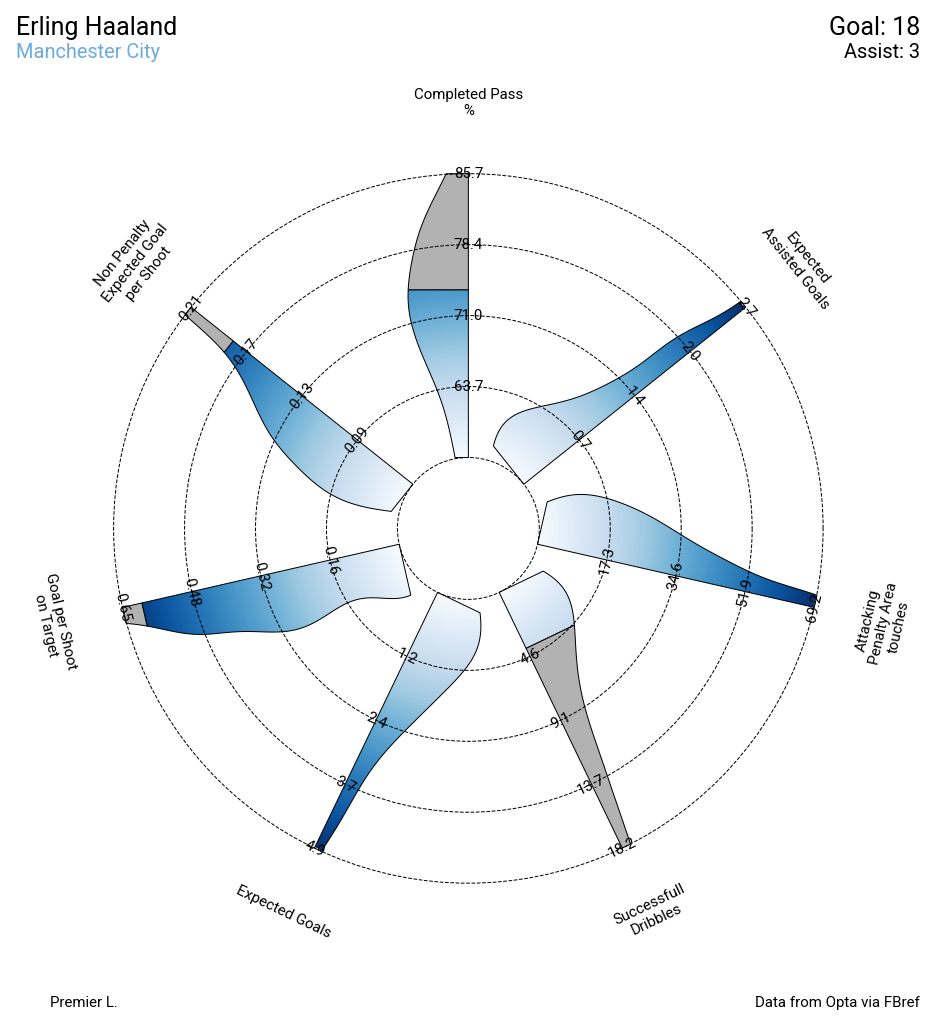

In [8]:
low = df_uk[params].quantile(0.05).values
high = df_uk[params].quantile(0.95).values
#lower_is_better = ['Cmp_percent_Total']
radar = Radar(params, low, high, num_rings=4)
def BuildRadar(df, player, team, team_color, league, goaltext, assisttext, params, c_map):
    # creating the figure using the grid function from mplsoccer:
    fig, axs = grid(figheight=14, grid_height=0.915, title_height=0.06, endnote_height=0.025,
                    title_space=0, endnote_space=0, grid_key='radar', axis=False)

    # plot the turbine plot
    radar.setup_axis(ax=axs['radar'])
    # plot the turbine blades. Here we give the player_Values and
    # the value for all players shape=(1000, 11)
    player_values = df.loc[df.Player == player, params].values[0]
    turbine_output = radar.turbine(player_values, df[params].values, ax=axs['radar'], kwargs_inner={'edgecolor': 'black'},
                                    kwargs_inner_gradient={'cmap': c_map}, kwargs_outer={'facecolor': '#b2b2b2', 'edgecolor': 'black'})
    # plot some dashed rings and the labels for the values and parameter names
    rings_inner = radar.draw_circles(ax=axs['radar'], facecolor='None',
                                 edgecolor='black', linestyle='--')
    range_labels = radar.draw_range_labels(ax=axs['radar'], fontsize=15,
                                       fontproperties=fm.prop, zorder=1)
    param_labels = radar.draw_param_labels(ax=axs['radar'], fontsize=15,
                                       fontproperties=fm.prop, zorder=1)

    # adding a title and endnote
    title1_text = axs['title'].text(0.01, 0.65, player, fontsize=25,
                                    fontproperties=fm.prop, ha='left', va='center')
    title2_text = axs['title'].text(0.01, 0.25, team, fontsize=20,
                                    fontproperties=fm.prop, ha='left', va='center', color=team_color)
    title3_text = axs['title'].text(0.99, 0.65, goaltext, fontsize=25,
                                    fontproperties=fm.prop, ha='right', va='center')
    title4_text = axs['title'].text(0.99, 0.25, assisttext, fontsize=20,
                                    fontproperties=fm.prop, ha='right', va='center')
    endnote_text1 = axs['endnote'].text(0.12, 0.5, league, fontsize=15,
                                        fontproperties=fm.prop, ha='right', va='center')
    endnote_text2 = axs['endnote'].text(0.99, 0.5, 'Data from Opta via FBref', fontsize=15,
                                        fontproperties=fm.prop, ha='right', va='center')
BuildRadar(df_list[0], TopScorer[0], Team[0], Colors[0], Leagues[0], GoalT[0], AssistT[0], params, C_Map[0])

### * Osimhen

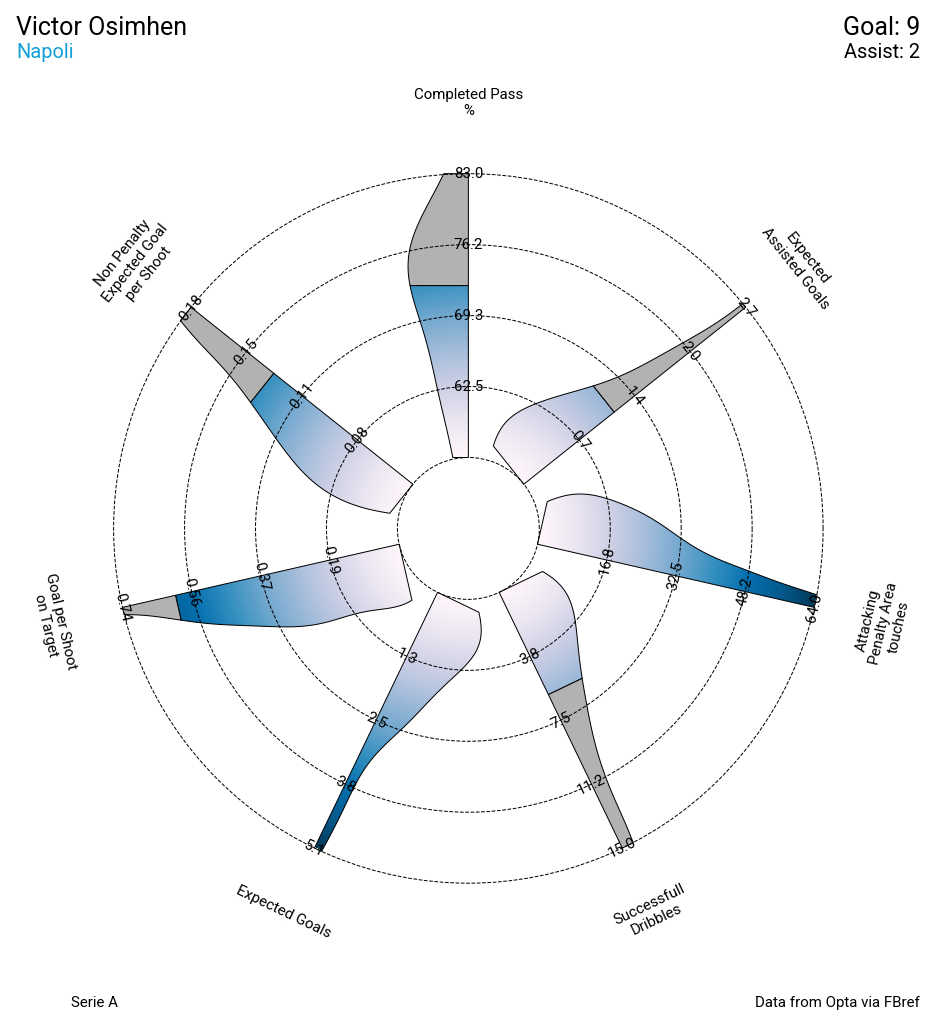

In [9]:
low = df_it[params].quantile(0.05).values
high = df_it[params].quantile(0.95).values
#lower_is_better = ['Cmp_percent_Total']
radar = Radar(params, low, high, num_rings=4)
BuildRadar(df_list[1], TopScorer[1], Team[1], Colors[1], Leagues[1], GoalT[1], AssistT[1], params, C_Map[1])

### * Lewandowski

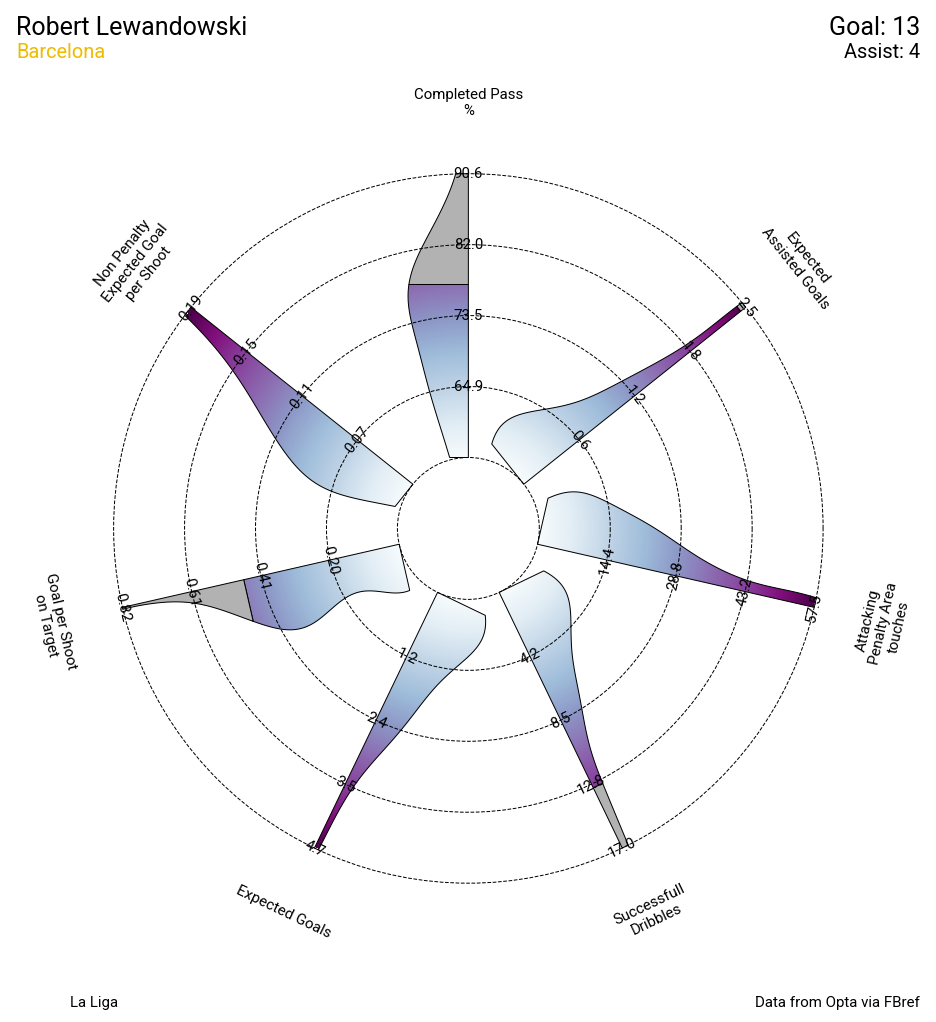

In [10]:
low = df_es[params].quantile(0.05).values
high = df_es[params].quantile(0.95).values
#lower_is_better = ['Cmp_percent_Total']
radar = Radar(params, low, high, num_rings=4)
BuildRadar(df_list[2], TopScorer[2], Team[2], Colors[2], Leagues[2], GoalT[2], AssistT[2], params, C_Map[2])

### * Nkunku

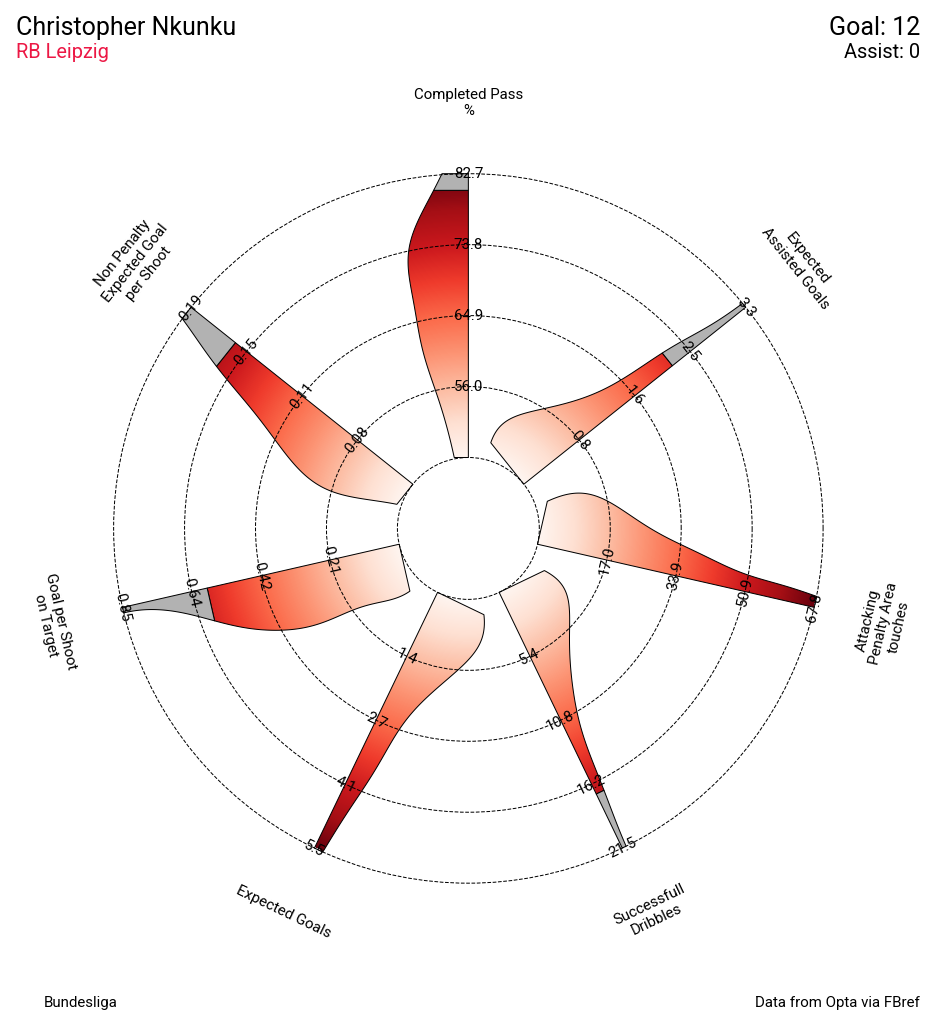

In [11]:
low = df_ge[params].quantile(0.05).values
high = df_ge[params].quantile(0.95).values
#lower_is_better = ['Cmp_percent_Total']
radar = Radar(params, low, high, num_rings=4)
BuildRadar(df_list[3], TopScorer[3], Team[3], Colors[3], Leagues[3], GoalT[3], AssistT[3], params, C_Map[3])

### * Neymar

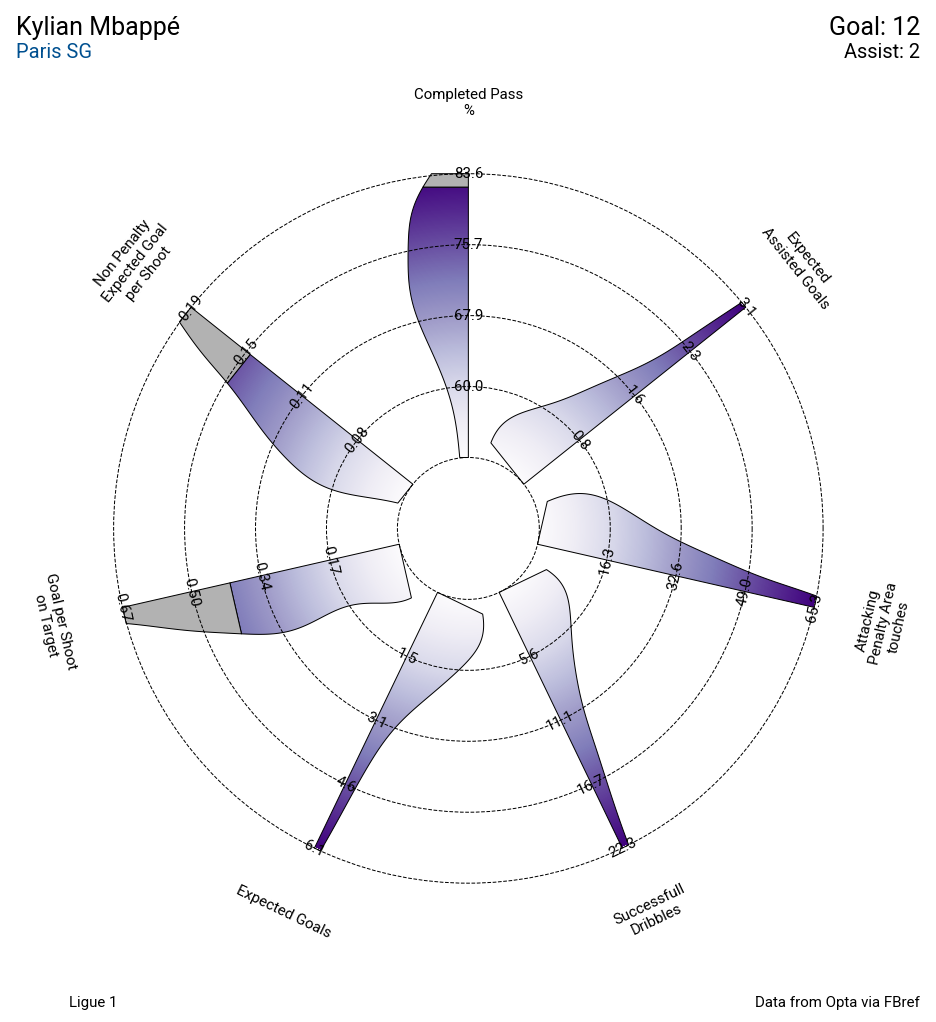

In [12]:
low = df_fr[params].quantile(0.05).values
high = df_fr[params].quantile(0.95).values
#lower_is_better = ['Cmp_percent_Total']
radar = Radar(params, low, high, num_rings=4)
BuildRadar(df_list[4], TopScorer[4], Team[4], Colors[4], Leagues[4], GoalT[4], AssistT[4], params, C_Map[4])